In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Ball:
    def __init__(self, center, radius):
        self.coordinates = center
        self.radius = radius
        self.P = np.pi * self.radius ** 2

    def calc_P(self, r):
        return np.pi * r ** 2

    def to_bound_balls(self, ball1, ball2):
        self.coordinates = [(ball1.coordinates[i] + ball2.coordinates[i]) / 2 for i in range(len(ball1.coordinates))]
        pom = max(ball1.radius, ball2.radius)
        self.radius = ((self.coordinates[0] - ball1.coordinates[0])**2 + (self.coordinates[1] - ball1.coordinates[1])**2)**0.5 + pom + 0.1
        #print(self.radius)

    def expand_to_balls(self, other):
        
        if not isinstance(other, Ball):
            raise TypeError("Argument must be an instance of Ball.")

        # Izračunaj udaljenost između centara
        distance = sum((c1 - c2) ** 2 for c1, c2 in zip(self.coordinates, other.coordinates)) ** 0.5

        # Ako je trenutna lopta već dovoljno velika, nije potrebno proširiti
        if distance + other.radius <= self.radius:
            return

        # Ako druga lopta obuhvata trenutnu, uzmi njene parametre
        if distance + self.radius <= other.radius:
            self.coordinates = other.coordinates[:]
            self.radius = other.radius
            return
            #return self.calc_P(other.radius)


        #Ažuriraj centar
        new_center = [(self.coordinates[0] + other.coordinates[0]) / 2, (self.coordinates[1] + other.coordinates[1]) / 2]
        pom = max(self.radius, other.radius)
        new_radius = (distance / 2) + pom + 0.1
        
        self.coordinates = new_center
        self.radius = new_radius
        

In [3]:
class BallTreeNode:
    def __init__(self, ball=None, parent=None, left=None, right=None):
        self.ball = ball 
        self.parent = parent 
        self.left = left       
        self.right = right

    def set_ball(self, ball):
        self.ball = ball

    def set_left(self, left):
        self.left = left

    def set_right(self, right):
        self.right = right

    def set_parent(self, parent):
        self.parent = parent

    def get_ball(self):
        return self.ball

    def get_left(self):
        return self.left

    def get_right(self):
        return self.right

    def get_parent(self):
        return self.parent

In [4]:
class BallTree:
    def __init__(self, balls, root=None):
        self.balls = balls  # Lista lopti
        self.costs = [0] * len(self.balls)
        self.root = self.build_balltree_range(0, len(balls)-1)
        
    def fill_costs(self, l, u):
        
        bl = Ball(self.balls[l].coordinates, self.balls[l].radius)
        # Popuni levi deo
        for i in range(l, u+1):
            bl.expand_to_balls(self.balls[i])
            self.costs[i-1] = bl.calc_P(bl.radius)
            #self.costs[i] = bl.expand_to_balls(self.balls[i])
            #print("i:")
            #print(i)

        bl = Ball(self.balls[u].coordinates, self.balls[u].radius)  # Inicijalizacija sa poslednjom loptom
        # Popuni desni deo
        for i in range(u, l-1, -1):
            bl.expand_to_balls(self.balls[i])
            self.costs[i - 1] += bl.calc_P(bl.radius)
            #self.costs[i-1] += bl.expand_to_balls(self.balls[i])
            

    def build_balltree_range(self, l, u):
        if l == u:
            leaf = BallTreeNode()
            leaf.set_ball(self.balls[l])
            return leaf
        else:
            best_dim = 0
            best_loc = l
            best_cost = float('inf')

            for i in range(len(self.balls[0].coordinates)):
                self.balls[l:u+1] = sorted(
                    self.balls[l:u+1],
                    key = lambda b : b.coordinates[i]
                )
                self.fill_costs(l,u)
                if i == 0:
                    best_cost = self.costs[l]
                for j in range(l, u):
                    if self.costs[j] < best_cost:
                        best_cost = self.costs[j]
                        best_dim = i
                        best_loc = j


            self.balls[l:u+1] = sorted(
                    self.balls[l:u+1],
                    key = lambda b : b.coordinates[best_dim]
            )


            node = BallTreeNode()
            node.set_left(self.build_balltree_range(l, best_loc))
            node.get_left().set_parent(node)
            node.set_right(self.build_balltree_range(best_loc+1, u))
            node.get_right().set_parent(node)
        
            ball = Ball([0,0], 0)
            ball.to_bound_balls(node.get_left().get_ball(), node.get_right().get_ball())
            node.set_ball(ball)

            return node
                

In [5]:
balls = [
    Ball([1, 2], 0.5), #A
    Ball([2.1, 4], 0.6), #C
    Ball([2.03,2], 0.6),  #B
    Ball([6, 5], 0.5),  #E
    Ball([4, 6], 0.2), #D
    Ball([7,3], 0.5),#F
    Ball([8, 4.5], 0.4)
]

In [6]:
ball_tree = BallTree(balls)

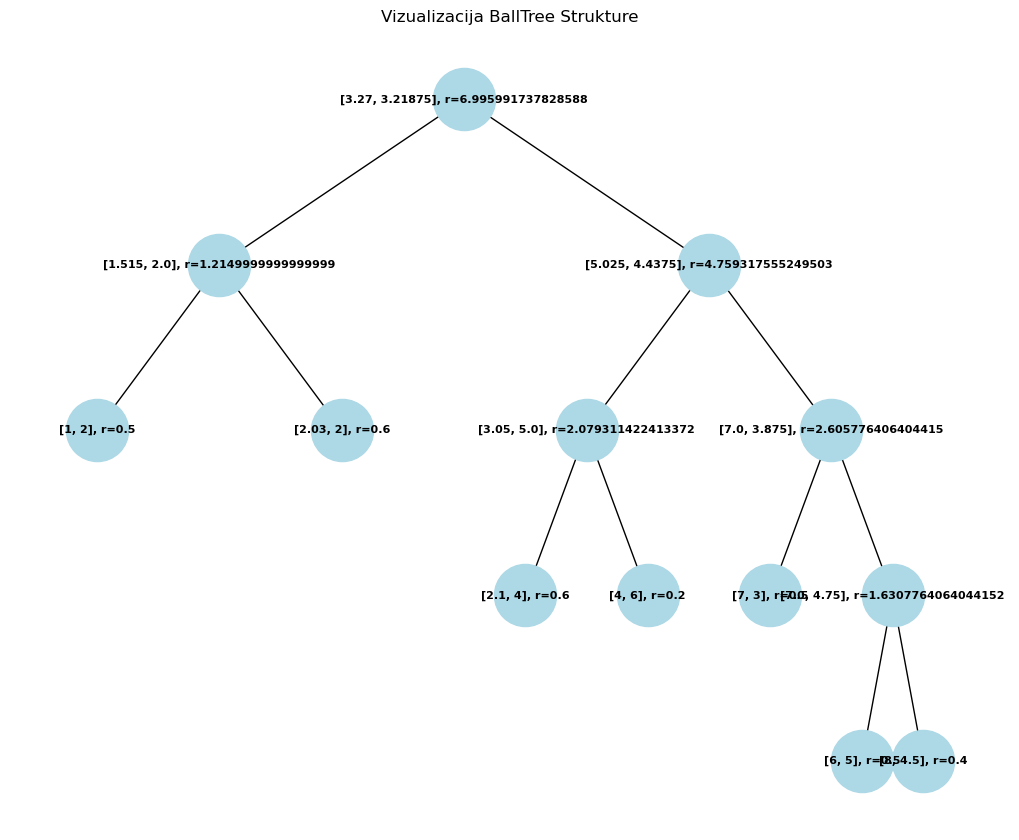

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_ball_tree(node, pos=None, level=0, x=0, dx=1.0, graph=None, labels=None):
    """ Pomoćna funkcija za rekursivno crtanje BallTree strukture. """
    if pos is None:
        pos = {}
    if graph is None:
        graph = nx.Graph()
    if labels is None:
        labels = {}

    pos[node] = (x, -level)
    labels[node] = f"{node.ball.coordinates}, r={node.ball.radius}"

    # Ako ima levog deteta, dodaj u graf i rekurzivno pozovi za levo dete
    if node.left is not None:
        graph.add_edge(node, node.left)
        plot_ball_tree(node.left, pos=pos, level=level + 1, x=x - dx, dx=dx / 2, graph=graph, labels=labels)
    # Ako ima desnog deteta, dodaj u graf i rekurzivno pozovi za desno dete
    if node.right is not None:
        graph.add_edge(node, node.right)
        plot_ball_tree(node.right, pos=pos, level=level + 1, x=x + dx, dx=dx / 2, graph=graph, labels=labels)

    return graph, pos, labels

# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(ball_tree.root)

# Crtanje grafa
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/topdown_graph1.png')
plt.show()

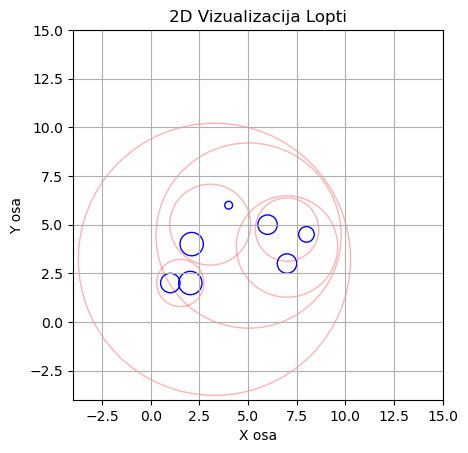

In [8]:
def plot_ball(ax, ball, color='b', alpha=1.0):
    """ Pomoćna funkcija za crtanje kruga. """
    circle = plt.Circle(ball.coordinates, ball.radius, color=color, fill=False, alpha=alpha)
    ax.add_artist(circle)

def plot_tree(node, ax, level=0, max_level=10):
    """ Rekurzivno prolazi kroz BallTree i crta sve lopte. """
    if node is None or level > max_level:
        return
    plot_ball(ax, node.ball, color='r' if node.left or node.right else 'b', alpha=0.3 if node.left or node.right else 1.0)
    plot_tree(node.left, ax, level+1, max_level)
    plot_tree(node.right, ax, level+1, max_level)

# Kreiranje grafika
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(ball_tree.root, ax)

# Podesavanje osa
ax.set_xlim(-4, 15)
ax.set_ylim(-4, 15)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')
plt.savefig('results/topdown1.png')
plt.show()


In [9]:
np.random.seed(42)
balls2= []
for _ in range(20):
    x = np.random.random() * 30
    y = np.random.random() * 30
    r = 1
    ball = Ball([x, y], r)
    balls2.append(ball)

In [10]:
tree = BallTree(balls2)

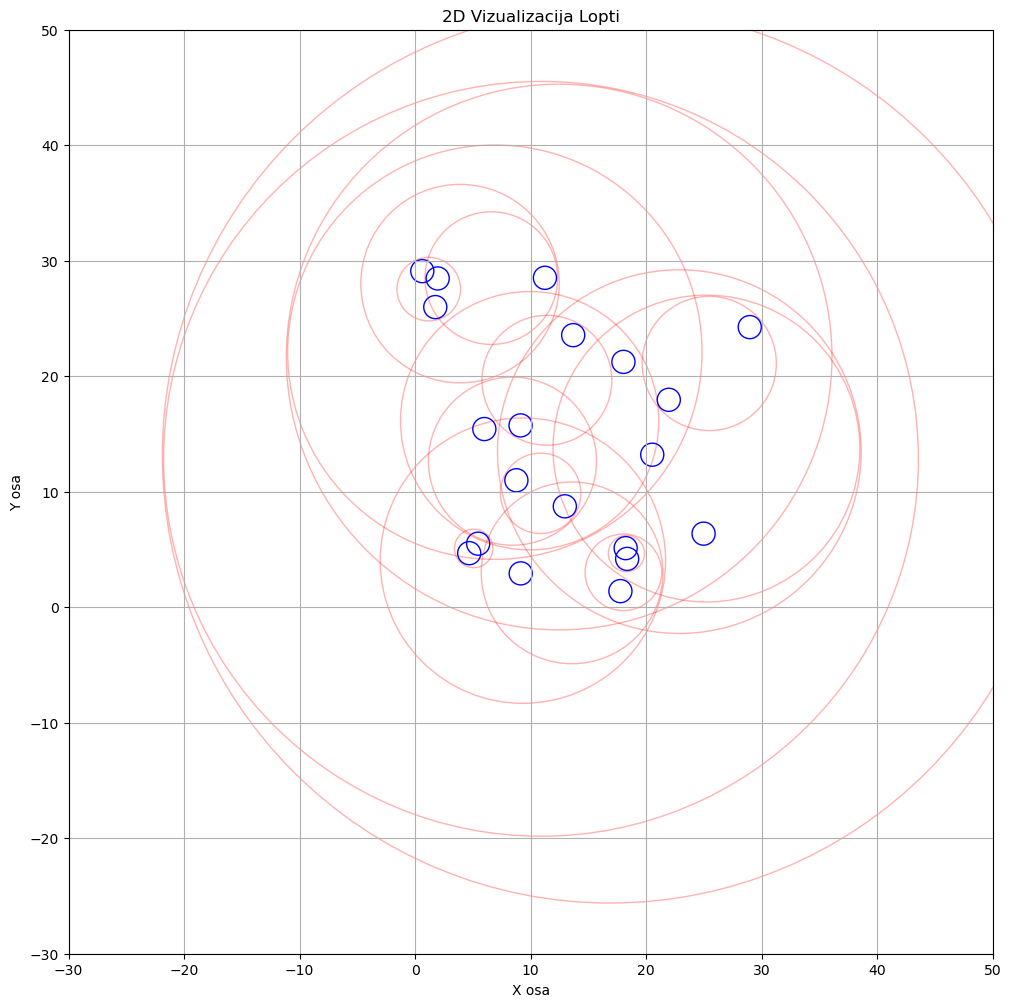

In [11]:
# Kreiranje grafika
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(tree.root, ax)

# Podesavanje osa
ax.set_xlim(-30, 50)
ax.set_ylim(-30, 50)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')
plt.savefig('results/topdown2.png')

plt.show()

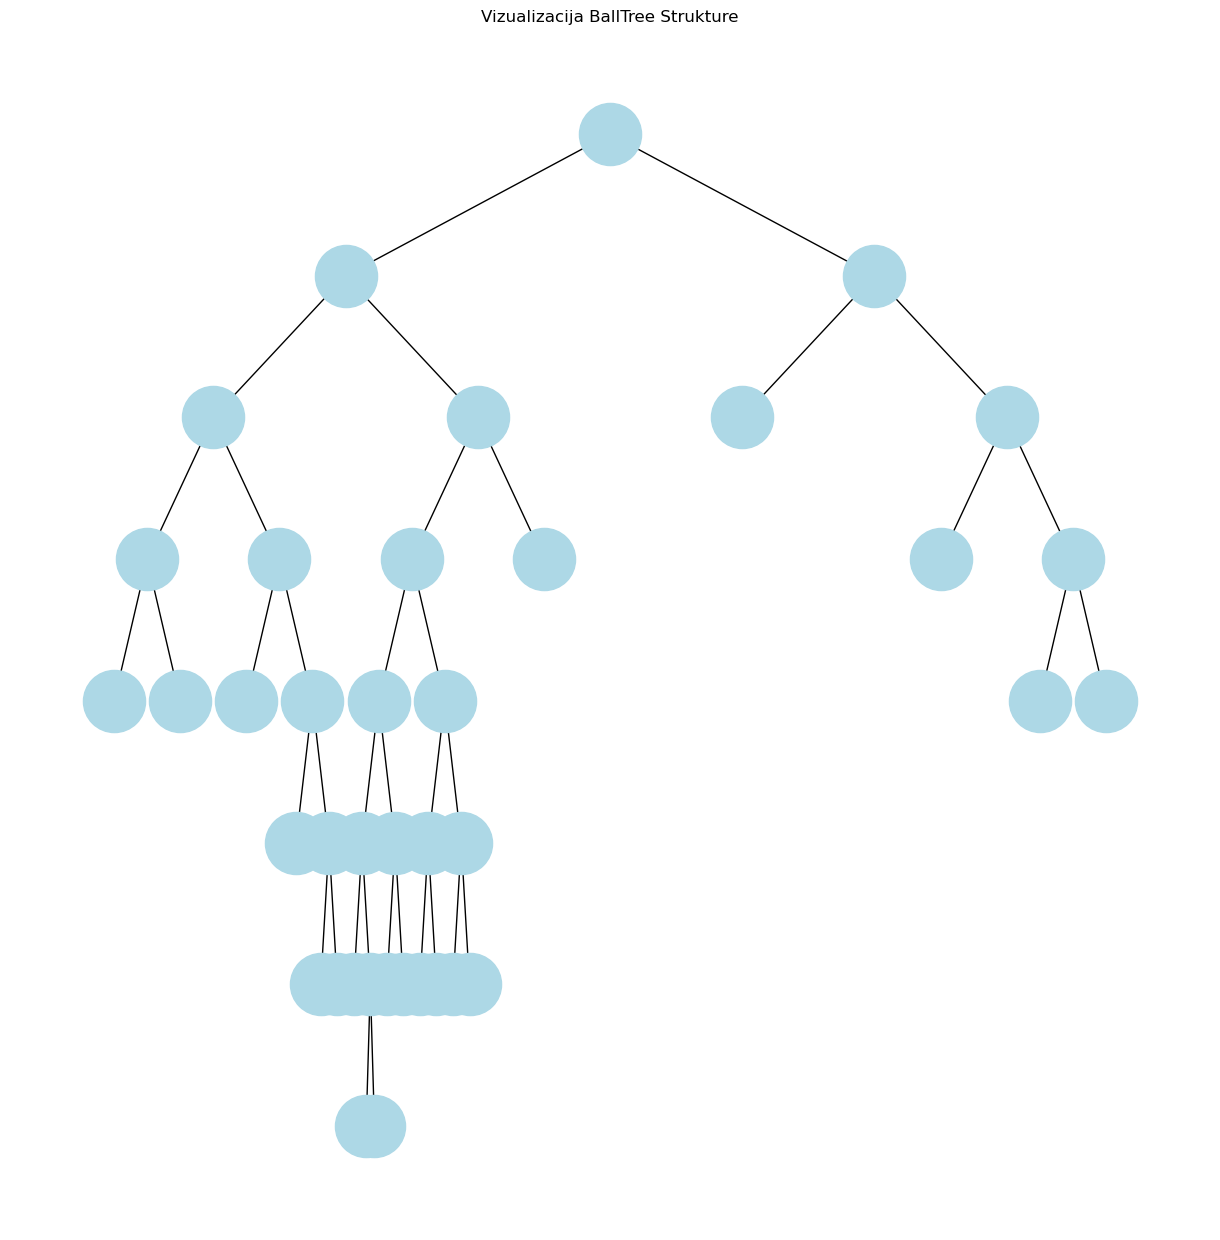

In [12]:
# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(tree.root)

# Crtanje grafa
plt.figure(figsize=(12, 12))
nx.draw(graph, pos, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/toptown_graph2.png')
plt.show()

In [17]:
# merenje vremena izvrsavanja

import time

np.random.seed(42)
balls3= []
vol_leaf = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 190, 200]
result_time = []
for v in vol_leaf:
    for _ in range(v):
        x = np.random.random() * 100
        y = np.random.random() * 100
        r = 1
        ball = Ball([x, y], r)
        balls3.append(ball)
    start_time = time.time()
    tree = BallTree(balls3)
    end_time = time.time()
    result_time.append(end_time-start_time)

In [18]:
result_time

[0.0008916854858398438,
 0.003019571304321289,
 0.008379220962524414,
 0.014812946319580078,
 0.022134780883789062,
 0.01950812339782715,
 0.025294780731201172,
 0.06538844108581543,
 0.14674973487854004,
 0.10978007316589355,
 0.24072647094726562,
 0.20918869972229004,
 0.26119470596313477,
 0.29406237602233887,
 0.3863976001739502,
 0.46689796447753906,
 0.47803258895874023,
 0.6028227806091309,
 0.5563249588012695,
 0.40225815773010254,
 0.5153429508209229,
 1.7773511409759521,
 1.9851531982421875,
 1.8832910060882568,
 3.1559300422668457,
 4.14704442024231,
 2.9845476150512695,
 8.503194332122803]

In [19]:
with open('top_down_time.txt', 'w') as f:
    for x in result_time:
        f.wrtite(f'{x}\n')

AttributeError: '_io.TextIOWrapper' object has no attribute 'wrtite'